In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer
import sys
import time
import os
from tqdm import tqdm
sys.path.append('../preprocessing/DataSet/')
from DBhandle import DBconn #DBhandle.py 파일 확인
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, Model, optimizers, metrics
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, BatchNormalization, Dense, Lambda, Reshape, UpSampling1D,Flatten, Input, LeakyReLU, Activation
from tensorflow.keras.layers import (
    AvgPool1D,
    AvgPool2D,
    GlobalAveragePooling1D,
    GlobalAveragePooling2D,
    MaxPool1D,
    MaxPool2D,
    Conv1D,
    Conv2D,
    Conv1DTranspose,
    Conv2DTranspose,
    Layer
)
from tensorflow.keras.layers import ReLU, concatenate

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #초기화할 GPU Number
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.python.client import device_lib

In [2]:
from tensorflow.python.keras.utils.data_utils import Sequence

In [3]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
#session.close()

In [4]:
db = DBconn()

In [5]:
db.ShowTables()

['SeverityNormal_MachineAFibFlut',
 'SeverityNormal_TechIndiAFibFlut',
 'patient_info_2010_2021_Dx',
 'patient_info_changwon',
 'patient_info_kbsmc',
 'smc_health_study_2008_2022',
 'smc_health_study_normal_30_730',
 'smc_health_study_afib',
 'patient_info_all']

In [6]:
db = DBconn()
df = db.selectTableData('patient_info_all')

In [155]:
class DataGenerator(Sequence):
    def __init__(self, unique_ids,  batch_size=128, dim=(4800,12),n_classes=2, shuffle=False):
        
        self.dim = dim
        self.batch_size = batch_size
        self.unique_ids = unique_ids
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.indexes = np.arange(len(unique_ids))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.unique_ids) / self.batch_size))
    
    @property
    def shape(self):
        return self.unique_ids.shape

    def __getitem__(self, index):
        #print(index)
        if((index+1)*self.batch_size>len(self.unique_ids)): #마지막 batch 데이터
            indexes = self.indexes[index*self.batch_size:len(self.unique_ids)]
        else:
            indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size] #0 부터 배치 사이즈까지 self.indexes

        list_unique_ids_temp = [self.unique_ids[k] for k in indexes]

        # Generate data
        X= self.__data_generation(list_unique_ids_temp)
        
        return X

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_unique_ids_temp):
        scaler = StandardScaler()
        # Initialization
        if(len(list_unique_ids_temp)<self.batch_size): #마지막 batch 내 데이터
            last_size = len(self.unique_ids) % self.batch_size
            X = np.empty((last_size, *self.dim))
        else:
            X = np.empty((self.batch_size, *self.dim))

        # Generate data
        for i, ID in enumerate(list_unique_ids_temp):
            # Store sample:
            ecg_wave = np.load('/smc_work/' + ID + '.npy')
            ecg_wave = scaler.fit_transform(ecg_wave)
            #X[i,] = ecg_wave[:,1].reshape(-1,5000)
            try:
                X[i,] = ecg_wave[100:4900,:]
            except ValueError:
                #ecg_wave = np.resize(ecg_wave, (4800,12,1))
                ecg_wave = np.delete(ecg_wave, range(100))
                ecg_wave = np.delete(ecg_wave, range(-100, 0))
                ecg_wave = np.resize(ecg_wave, (4800,12,1))
                X[i,] = ecg_wave
                
            
        return X

In [156]:
df_train = df.sample(frac=0.7,random_state=0)
df_train.reset_index(drop=True,inplace=True)

In [157]:
df_test = df[~df['unique_id'].isin(df_train['unique_id'])].copy()
df_test.reset_index(drop=True,inplace=True)

In [158]:
params = {'dim': (4800,12,1),
          'batch_size': 10240,
          'n_classes': 2,
          'shuffle': False}

train_dataset = DataGenerator(df_train['unique_id'][:10240], **params)
test_dataset = DataGenerator(df_test['unique_id'][:10240], **params)
#valid_dataset = DataGenerator(df_valid['unique_id'],df_valid['label'], **params)

In [159]:
train_dataset[0].shape

(10240, 4800, 12, 1)

In [11]:
def sampling(args):
    """Reparameterization trick. Instead of sampling from Q(z|X), 
    sample eps = N(0,I) z = z_mean + sqrt(var)*eps.
    Parameters:
    -----------
    args: list of Tensors
        Mean and log of variance of Q(z|X)
    Returns
    -------
    z: Tensor
        Sampled latent vector
    """

    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z

In [178]:
z_dim = 16

# The Encoder 
# ************
encoder_input = Input(shape=(4800,12,1))
x = encoder_input
x = Conv2D(filters = 32, kernel_size = (8,1), strides = (2,1), padding='same', activation = 'elu')(x)
x = Conv2D(filters = 64, kernel_size = (8,1), strides = (2,1), padding='same', activation = 'elu')(x)
x = Conv2D(filters = 128, kernel_size = (8,1), strides = (2,1), padding='same', activation = 'elu')(x)

shape_before_flattening = K.int_shape(x)[1:]  # B is the tensorflow.keras backend ! See last post. 

x = Flatten()(x)
# differences to AE-models. The following layers central elements of VAEs!   
mu      = Dense(z_dim, name='mu')(x)
log_var = Dense(z_dim, name='log_var')(x)

# We calculate z-points/vectors in the latent space by a special function
# used by a Keras Lambda layer   
enc_out = Lambda(sampling, name='enc_out_z')([mu, log_var])    

# The Encoder model 
encoder = Model(encoder_input, [enc_out], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_48 (InputLayer)          [(None, 4800, 12, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_42 (Conv2D)             (None, 2400, 12, 32  288         ['input_48[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_43 (Conv2D)             (None, 1200, 12, 64  16448       ['conv2d_42[0][0]']              
                                )                                                           

In [176]:
shape_before_flattening

(600, 12, 128)

In [179]:
dec_inp_z = Input(shape=(z_dim))
x = Dense(np.prod(shape_before_flattening))(dec_inp_z)
x = Reshape(shape_before_flattening)(x)
x = Conv2DTranspose(filters=128, kernel_size=(8,1), strides=(2,1), padding='same', activation = 'elu')(x)
x = Conv2DTranspose(filters=64, kernel_size=(8,1), strides=(2,1), padding='same', activation = 'elu')(x)
x = Conv2DTranspose(filters=32,  kernel_size=(8,1), strides=(2,1), padding='same', activation = 'elu')(x)
x = Conv2DTranspose(filters=1,  kernel_size=(8,1), strides=(1,1), padding='same', activation = 'elu')(x)
dec_out = x
decoder = Model([dec_inp_z], [dec_out], name="decoder")

decoder.summary()

enc_output = encoder(encoder_input)
decoder_output = decoder(enc_output)
vae_pre = Model(encoder_input, decoder_output, name="vae_witout_kl_loss")

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 16)]              0         
                                                                 
 dense_28 (Dense)            (None, 921600)            15667200  
                                                                 
 reshape_27 (Reshape)        (None, 600, 12, 128)      0         
                                                                 
 conv2d_transpose_81 (Conv2D  (None, 1200, 12, 128)    131200    
 Transpose)                                                      
                                                                 
 conv2d_transpose_82 (Conv2D  (None, 2400, 12, 64)     65600     
 Transpose)                                                      
                                                                 
 conv2d_transpose_83 (Conv2D  (None, 4800, 12, 32)     1641

In [180]:
class CustVariationalLayer (Layer):
    
    def vae_loss(self, x_inp_ecg, z_reco_ecg):
        # The references to the layers are resolved outside the function 
        x = K.flatten(x_inp_ecg)   # B: tensorflow.keras.backend
        z = K.flatten(z_reco_ecg)
        
        # reconstruction loss per sample 
        # Note: that this is averaged over all features (e.g.. 784 for MNIST) 
        reco_loss = metrics.MSE(x, z)
        #mse = tf.keras.losses.MeanSquaredError(
         #   reduction=tf.keras.losses.Reduction.SUM)
        #reco_loss = mse(x, z)
        
        # KL loss per sample - we reduce it by a factor of 1.e-3 
        # to make it comparable to the reco_loss  
        kln_loss  = -0.5 * K.mean(1 + log_var - K.square(mu) - K.exp(log_var), axis=1) 
        # mean per batch (axis = 0 is automatically assumed) 
        return K.mean(reco_loss + kln_loss), K.mean(reco_loss), K.mean(kln_loss) 
           
    def call(self, inputs):
        inp_ecg = inputs[0]
        out_ecg = inputs[1]
        total_loss, reco_loss, kln_loss = self.vae_loss(inp_ecg, out_ecg)
        self.add_loss(total_loss, inputs=inputs)
        self.add_metric(total_loss, name='total_loss', aggregation='mean')
        self.add_metric(reco_loss, name='reco_loss', aggregation='mean')
        self.add_metric(kln_loss, name='kl_loss', aggregation='mean')
        
        return out_ecg  #not really used in this approach  

In [181]:
enc_output = encoder(encoder_input)
decoder_output = decoder(enc_output)

# add the custom layer to the model  
fc = CustVariationalLayer()([encoder_input, decoder_output])

vae = Model(encoder_input, fc, name="vae")
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_48 (InputLayer)          [(None, 4800, 12, 1  0           []                               
                                )]                                                                
                                                                                                  
 encoder (Functional)           (None, 16)           29573632    ['input_48[0][0]']               
                                                                                                  
 decoder (Functional)           (None, 4800, 12, 1)  15880673    ['encoder[1][0]']                
                                                                                                  
 cust_variational_layer_7 (Cust  (None, 4800, 12, 1)  0          ['input_48[0][0]',             

In [182]:
vae.compile(optimizer=Adam(), loss=None)

In [183]:
train_dataset[0].shape

(10240, 4800, 12, 1)

In [184]:
n_epochs = 3
batch_size = 128
vae.fit( x=train_dataset[0], y=None, shuffle=True, 
         epochs = n_epochs, batch_size=batch_size,validation_data=(test_dataset[0],None))

Train on 10240 samples, validate on 10240 samples
Epoch 1/3
10240/10240 [==============================] - ETA: 0s - loss: 1.4745 - total_loss: 1.4745 - reco_loss: 0.9874 - kl_loss: 0.4871

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


10240/10240 [==============================] - 88s 9ms/sample - loss: 1.4745 - total_loss: 1.4745 - reco_loss: 0.9874 - kl_loss: 0.4871 - val_loss: 1.0120 - val_total_loss: 1.0120 - val_reco_loss: 0.9862 - val_kl_loss: 0.0259
Epoch 2/3
10240/10240 [==============================] - 85s 8ms/sample - loss: nan - total_loss: nan - reco_loss: nan - kl_loss: nan - val_loss: nan - val_total_loss: nan - val_reco_loss: nan - val_kl_loss: nan
Epoch 3/3
10240/10240 [==============================] - 83s 8ms/sample - loss: nan - total_loss: nan - reco_loss: nan - kl_loss: nan - val_loss: nan - val_total_loss: nan - val_reco_loss: nan - val_kl_loss: nan


In [186]:
pred = vae.predict(test_dataset[0])

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


#### Data 0 - 5000 까지 VAE로 학습후 Reconstruction 하면 대부분 초반 및 후반 데이터가 이상하다는 것을 확인할 수 있음

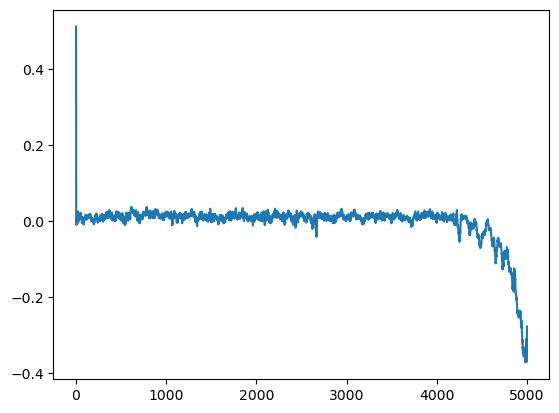

In [136]:
plt.plot(pred[22][:,1])
plt.show()

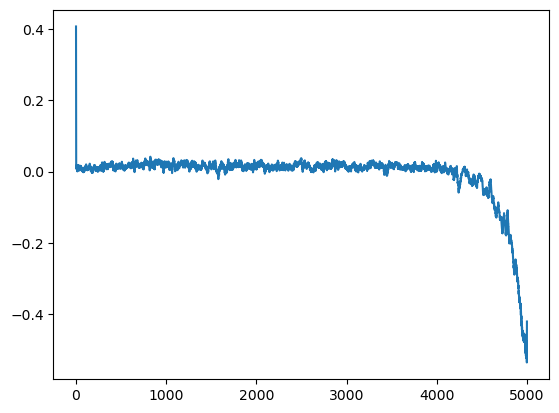

In [137]:
plt.plot(pred[22][:,2])
plt.show()

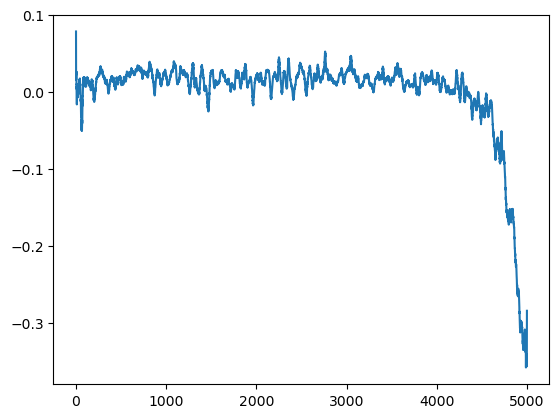

In [120]:
plt.plot(pred[25][:,1])
plt.show()

#### 맨 앞과 맨 뒤를 100개씩 날리고 다시 모델링

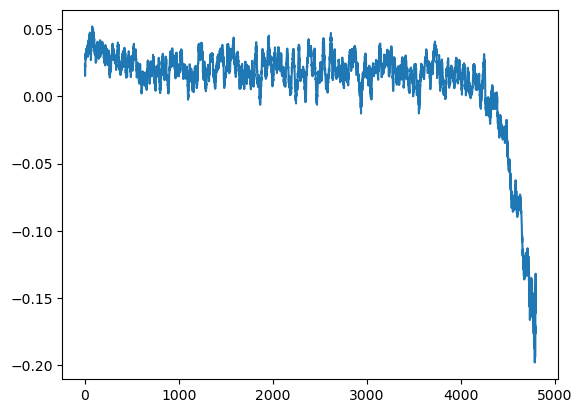

In [170]:
plt.plot(pred[22][:,1])
plt.show()

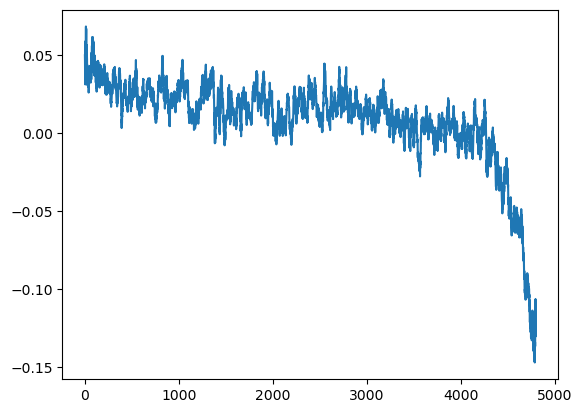

In [171]:
plt.plot(pred[22][:,2])
plt.show()

#### 잠재 차원을 2 -> 16 으로 증가

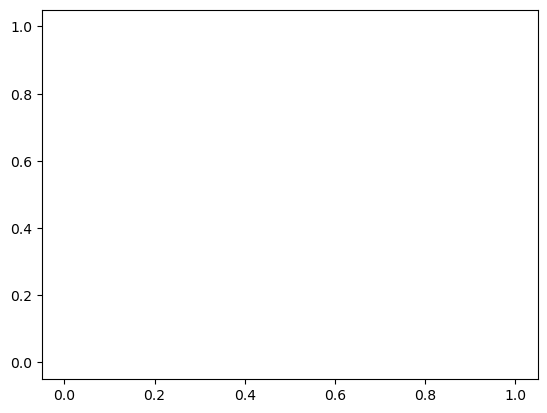

In [187]:
plt.plot(pred[22][:,2])
plt.show()